# Actividad 3: Análisis de Préstamos Lending Club con PySpark

## 1. Introducción
En esta actividad se realiza un análisis de datos de préstamos de la plataforma Lending Club. Usaremos PySpark para procesar un conjunto de datos de gran tamaño, limpiarlo, explorarlo y extraer conclusiones relevantes para la toma de decisiones financieras.

## 2. Carga y exploración del dataset

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when,mean, stddev, count, desc,to_date, year
from collections import Counter

In [44]:
spark = SparkSession.builder.appName("LendingClubLoanData").getOrCreate()
df = spark.read.option("header", True).option("inferSchema", True).csv("E:/Tareas/BigData/A3/loan.csv")

In [45]:
filas = df.count()
columnas = len(df.columns)
print(f"Registros: {filas} | Columnas: {columnas}")


Registros: 2260668 | Columnas: 145


In [46]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [47]:
tipos_dato = [field.dataType.simpleString() for field in df.schema.fields]
conteo_tipos = Counter(tipos_dato)
for tipo, cantidad in conteo_tipos.items():
    print(f"{tipo}: {cantidad} columnas")


string: 95 columnas
int: 42 columnas
double: 8 columnas


In [48]:
from pyspark.sql.functions import col, when, sum
from collections import defaultdict

total_rows = df.count()
resumen = defaultdict(lambda: {"con_muchos_nulos": 0, "pocos_nulos": 0})

# Recorremos columnas y analizamos por tipo
for campo in df.schema.fields:
    nombre = campo.name
    tipo = campo.dataType.simpleString()
    
    # Calcular cuántos nulos hay en la columna
    nulos = df.select((sum(when(col(nombre).isNull() | (col(nombre) == ''), 1).otherwise(0)) / total_rows).alias("nulo")).collect()[0]["nulo"]
    
    # Clasificamos según los criterios
    if nulos > 0.2:
        resumen[tipo]["con_muchos_nulos"] += 1
    elif nulos < 0.2:
        resumen[tipo]["pocos_nulos"] += 1

# Mostrar el resumen
print("Tipo\t|\t>20% nulos\t|\t<20% nulos")
for tipo, valores in resumen.items():
    print(f"{tipo}\t|\t{valores['con_muchos_nulos']}\t\t|\t{valores['pocos_nulos']}")


Tipo	|	>20% nulos	|	<20% nulos
string	|	46		|	49
int	|	11		|	31
double	|	1		|	7


In [49]:
total_rows = df.count()

# Calcular el porcentaje de nulos por columna
porcentaje_nulos = df.select([
    (sum(when(col(c).isNull() | (col(c) == ''), 1).otherwise(0)) / total_rows).alias(c)
    for c in df.columns
])

# Convertir a Pandas para filtrar más fácilmente
porcentaje_nulos_pd = porcentaje_nulos.toPandas().T
porcentaje_nulos_pd.columns = ["porcentaje_nulo"]
columnas_validas = porcentaje_nulos_pd[porcentaje_nulos_pd["porcentaje_nulo"] < 0.2].index.tolist()

# Dataset limpio conservando solo columnas con menos de 30% de nulos
df_clean = df.select(*columnas_validas)
print(f"Columnas seleccionadas: {len(columnas_validas)}")


Columnas seleccionadas: 87


In [50]:
df_clean.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullab

## 3. Limpieza de datos

In [52]:
col_importantes = ["loan_amnt", "funded_amnt", "term", "int_rate", "grade", "sub_grade","emp_length", "home_ownership", "annual_inc", "verification_status","loan_status", "purpose", "addr_state", "dti", "delinq_2yrs",
                   "earliest_cr_line", "inq_last_6mths", "issue_d", "last_pymnt_d", "revol_util", "total_acc", "open_acc", "total_pymnt","total_rec_prncp", "last_pymnt_amnt"]

df_reducido = df_clean.select(*col_importantes)


In [53]:
df_reducido.select( "loan_amnt", "funded_amnt", "term", "int_rate", "grade", "sub_grade","emp_length", "home_ownership", "annual_inc", "verification_status", "loan_status", "purpose", "addr_state", "dti", "delinq_2yrs").show(10, truncate=False)

+---------+-----------+----------+--------+-----+---------+----------+--------------+----------+-------------------+-----------+------------------+----------+-----+-----------+
|loan_amnt|funded_amnt|term      |int_rate|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose           |addr_state|dti  |delinq_2yrs|
+---------+-----------+----------+--------+-----+---------+----------+--------------+----------+-------------------+-----------+------------------+----------+-----+-----------+
|2500     |2500       | 36 months|13.56   |C    |C1       |10+ years |RENT          |55000     |Not Verified       |Current    |debt_consolidation|NY        |18.24|0          |
|30000    |30000      | 60 months|18.94   |D    |D2       |10+ years |MORTGAGE      |90000     |Source Verified    |Current    |debt_consolidation|LA        |26.52|0          |
|5000     |5000       | 36 months|17.97   |D    |D1       |6 years   |MORTGAGE      |59280     |Source Verified    

In [54]:
df_reducido.select( "earliest_cr_line", "inq_last_6mths", "issue_d", "last_pymnt_d", "revol_util", "total_acc", "open_acc", "total_pymnt","total_rec_prncp", "last_pymnt_amnt").show(10, truncate=False)

+----------------+--------------+--------+------------+----------+---------+--------+-----------+---------------+---------------+
|earliest_cr_line|inq_last_6mths|issue_d |last_pymnt_d|revol_util|total_acc|open_acc|total_pymnt|total_rec_prncp|last_pymnt_amnt|
+----------------+--------------+--------+------------+----------+---------+--------+-----------+---------------+---------------+
|Apr-2001        |1             |Dec-2018|Feb-2019    |10.3      |34       |9       |167.02     |113.98         |84.92          |
|Jun-1987        |0             |Dec-2018|Feb-2019    |24.2      |44       |13      |1507.11    |612.25         |777.23         |
|Apr-2011        |0             |Dec-2018|Feb-2019    |19.1      |13       |8       |353.89     |212.79         |180.69         |
|Feb-2006        |0             |Dec-2018|Feb-2019    |78.1      |13       |10      |286.71     |168.07         |146.51         |
|Dec-2000        |0             |Dec-2018|Feb-2019    |3.6       |26       |12      |1423.

In [55]:
len(df_reducido.columns)

25

In [57]:
df_reducido.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- last_pymnt_d: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- total_rec_prncp: string 

## 4. Análisis descriptivo y agrupaciones

In [59]:
df_reducido.select( "loan_amnt", "funded_amnt", "term", "int_rate", "grade", "sub_grade","emp_length", "home_ownership", "annual_inc", "verification_status","loan_status", "purpose", "addr_state", "dti", "delinq_2yrs").describe().show()

+-------+------------------+------------------+----------+-----------------+-------+---------+----------+--------------+-----------------+-------------------+-----------+--------------------+--------------------+------------------+------------------+
|summary|         loan_amnt|       funded_amnt|      term|         int_rate|  grade|sub_grade|emp_length|home_ownership|       annual_inc|verification_status|loan_status|             purpose|          addr_state|               dti|       delinq_2yrs|
+-------+------------------+------------------+----------+-----------------+-------+---------+----------+--------------+-----------------+-------------------+-----------+--------------------+--------------------+------------------+------------------+
|  count|           2260668|           2260668|   2260668|          2260668|2260668|  2260668|   2260668|       2260668|          2260664|            2260668|    2260668|             2260667|             2260667|           2258956|           22606

In [60]:
df_reducido.select( "earliest_cr_line", "inq_last_6mths", "issue_d", "last_pymnt_d", "revol_util", "total_acc", "open_acc", "total_pymnt","total_rec_prncp", "last_pymnt_amnt").describe().show()

+-------+------------------+------------------+---------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|summary|  earliest_cr_line|    inq_last_6mths|        issue_d|      last_pymnt_d|          revol_util|           total_acc|          open_acc|       total_pymnt|     total_rec_prncp|   last_pymnt_amnt|
+-------+------------------+------------------+---------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|  count|           2260638|           2260637|        2260668|           2258235|             2258834|             2260618|           2260558|           2260655|             2260659|           2260665|
|   mean|24.657378640776695| 0.577331070380116|           NULL|2011.9038054678804|   50.85820401710484|  24.455913212538377|11.612557687067126|11823.061164758208|   9299.725356411953| 3364

In [62]:
df_reducido.groupBy("loan_status").count().orderBy("count", ascending=False).show()
df_reducido.groupBy("home_ownership").agg({"int_rate": "avg"}).show()
df_reducido.groupBy("grade").avg("loan_amnt", "int_rate").orderBy("grade").show()
df_reducido.groupBy("purpose").count().orderBy("count", ascending=False).show()
df_reducido = df_reducido.withColumn("issue_date", to_date("issue_d", "MMM-yyyy"))
df_reducido = df_reducido.withColumn("issue_year", year("issue_date"))
df_reducido.groupBy("issue_year").count().orderBy("issue_year").show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1041952|
|             Current| 919695|
|         Charged Off| 261654|
|  Late (31-120 days)|  21897|
|     In Grace Period|   8952|
|   Late (16-30 days)|   3737|
|Does not meet the...|   1988|
|Does not meet the...|    761|
|             Default|     31|
|            Oct-2015|      1|
+--------------------+-------+

+--------------+------------------+
|home_ownership|     avg(int_rate)|
+--------------+------------------+
|           OWN|13.110367229518008|
|          RENT|13.515439224786146|
|      MORTGAGE|12.748763110136732|
|           ANY|12.919437751003972|
|       2 years|             10.99|
|          NONE|14.291481481481476|
|         OTHER|13.462142857142851|
+--------------+------------------+

+-----+------------------+------------------+
|grade|    avg(loan_amnt)|     avg(int_rate)|
+-----+------------------+------------------+
|    A|14603.343209545825|7.08

## 5. Visualización de resultados

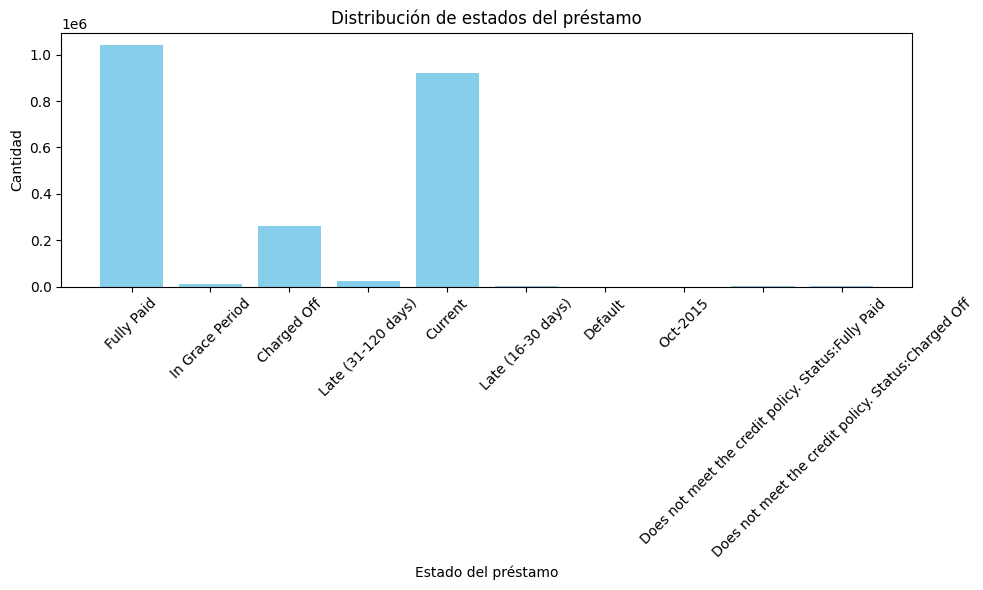

In [63]:
import matplotlib.pyplot as plt
loan_status_counts = df_reducido.groupBy("loan_status").count().toPandas()
plt.figure(figsize=(10,6))
plt.bar(loan_status_counts['loan_status'], loan_status_counts['count'], color='skyblue')
plt.title('Distribución de estados del préstamo')
plt.xlabel('Estado del préstamo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


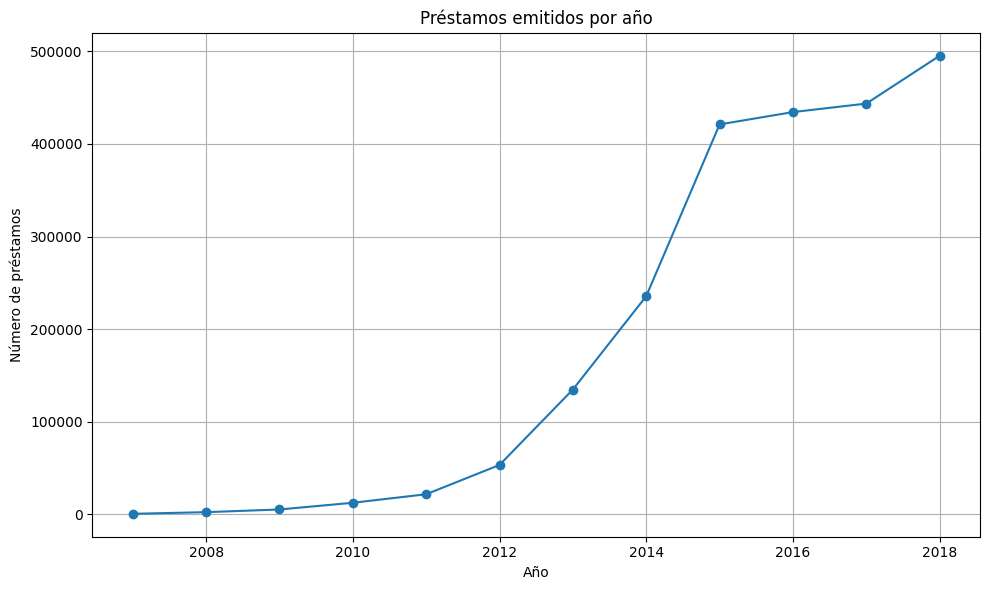

In [64]:
loans_by_year = df_reducido.groupBy("issue_year").count().orderBy("issue_year").toPandas()
plt.figure(figsize=(10,6))
plt.plot(loans_by_year["issue_year"], loans_by_year["count"], marker="o")
plt.title("Préstamos emitidos por año")
plt.xlabel("Año")
plt.ylabel("Número de préstamos")
plt.grid(True)
plt.tight_layout()
plt.show()


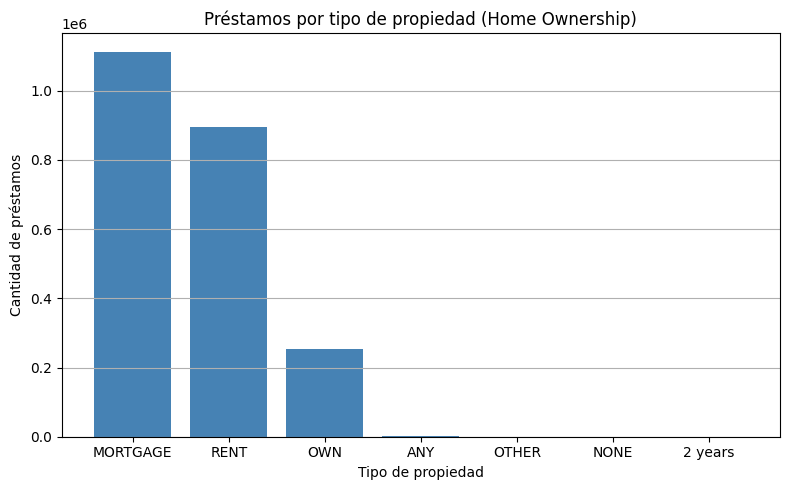

In [65]:
home_df = df_reducido.groupBy("home_ownership").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(8,5))
plt.bar(home_df["home_ownership"], home_df["count"], color='steelblue')
plt.title("Préstamos por tipo de propiedad (Home Ownership)")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad de préstamos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

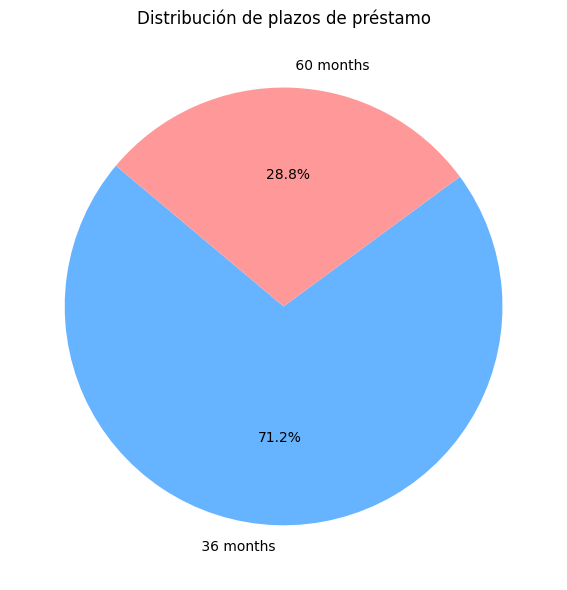

In [66]:
term_df = df_reducido.groupBy("term").count().toPandas()
plt.figure(figsize=(6,6))
plt.pie(term_df["count"], labels=term_df["term"], autopct='%1.1f%%', startangle=140, colors=["#66b3ff", "#ff9999"])
plt.title("Distribución de plazos de préstamo")
plt.tight_layout()
plt.show()